### 1. Connecting to the database

In [1]:
import json
from ahttpdc.reads.interface import DatabaseInterface

# load the secrets
with open('../secrets/secrets.json', 'r') as f:
    secrets = json.load(f)

# define sensors and what to read from them
sensors = {
    'bmp180': ['altitude', 'pressure', 'seaLevelPressure'],
    'mq135': ['aceton', 'alcohol', 'co', 'co2', 'nh4', 'toulen'],
    'ds18b20': ['temperature'],
    'dht22': ['humidity'],
}

# define the interface to the database
interface = DatabaseInterface(
    secrets['host'],
    secrets['port'],
    secrets['token'],
    secrets['organization'],
    secrets['bucket'],
    sensors,
    secrets['dev_ip'],
    80,
    secrets['handle'],
)

### 2. Procure the dataframe

In [2]:
import pandas as pd
import asyncio
from datetime import datetime, timedelta
from pathlib import Path

# if there is readings.csv file, load it
# if not - create it
readings_path = Path('../data/readings.csv')
if readings_path.is_file():
    sensor = pd.read_csv(readings_path)
    sensor["time"] = pd.to_datetime(sensor.time, format='ISO8601')
    sensor.set_index('time', inplace=True)
else:
    sensor = await interface.query_historical('-30d')
    sensor.to_csv(readings_path)

### 3. Prepare the data - resample and split into train and test sets

In [3]:
# columns to train against
columns = ['temperature', 'pressure', 'humidity']

# dicts to store
models = {}
predictions = {}

# resampling accordingly
df = sensor.copy().resample("1h").mean()
df = df.apply(lambda x: x.interpolate(method="time"))

# splits
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [8]:
train

,aceton,alcohol,altitude,co,co2,humidity,nh4,pressure,seaLevelPressure,temperature,toulen
time,,,,,,,,,,,
2024-05-16 17:00:00+00:00,0.483096,1.344884,149.915814,4.370392,402.807892,48.338808,4.160233,999.136715,1017.101294,24.703299,0.572878
2024-05-16 18:00:00+00:00,0.486138,1.353463,149.911757,4.391179,402.826849,48.173682,4.188922,999.474697,1017.444045,24.620133,0.576435
2024-05-16 19:00:00+00:00,0.506641,1.407004,149.932735,4.613789,402.925618,48.128560,4.311927,999.453535,1017.425103,24.641939,0.601471
2024-05-16 20:00:00+00:00,0.485103,1.351065,149.928904,4.381404,402.822559,48.073659,4.183466,999.539921,1017.512409,24.644192,0.575260
2024-05-16 21:00:00+00:00,0.477755,1.330677,149.931812,4.315415,402.780937,48.338754,4.125555,999.601325,1017.574891,24.649851,0.566459
...,...,...,...,...,...,...,...,...,...,...,...
2024-05-30 17:00:00+00:00,0.465250,1.299088,149.937625,4.172587,402.724730,48.103719,4.059268,999.537437,1017.509392,24.671140,0.551184
2024-05-30 18:00:00+00:00,0.490811,1.365189,149.906878,4.449323,402.846350,48.239685,4.209776,999.471142,1017.442441,24.651201,0.582343
2024-05-30 19:00:00+00:00,0.491801,1.367452,149.920020,4.462955,402.849792,48.285144,4.213267,999.403419,1017.371246,24.628742,0.583407


### 4. Determine the coeficcients of order as well as seasonal order for optimal **SARIMAX** results.

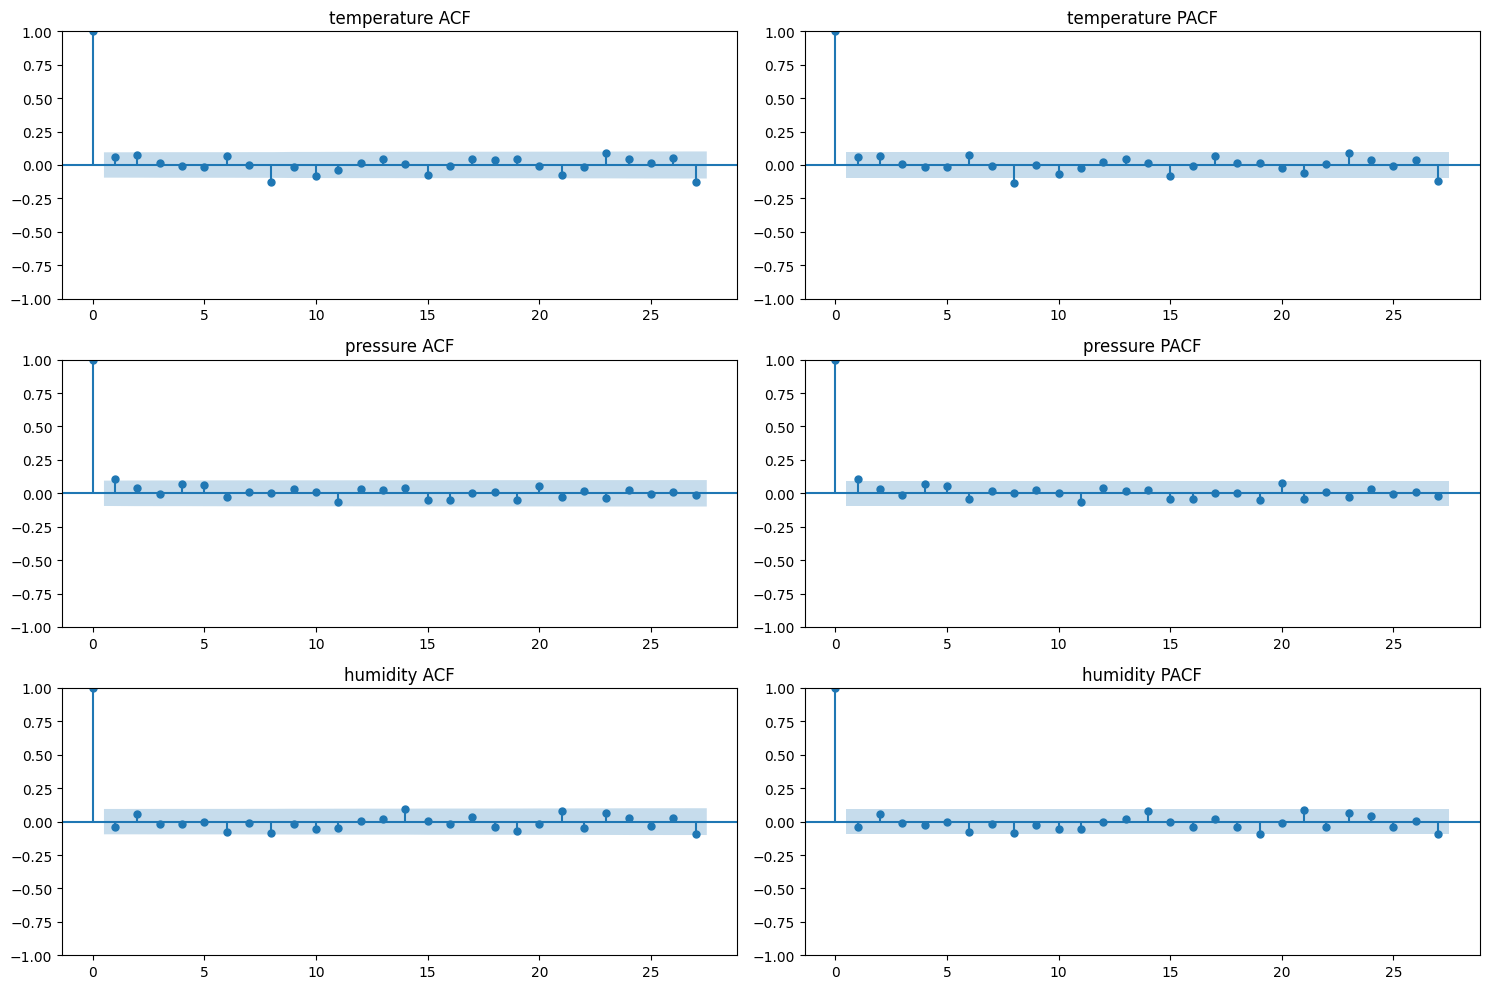

In [4]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=len(columns), ncols=2, figsize=(5 * len(columns), 10))

for i, param in enumerate(columns):
    sm.graphics.tsa.plot_acf(df[param], ax=axes[i, 0], title=f'{param} ACF')
    sm.graphics.tsa.plot_pacf(df[param], ax=axes[i, 1], title=f'{param} PACF')

plt.tight_layout()

plt.savefig('analysis-acf-pacf-plots.png')

### 5. Based on the graphs above set the order, and based on resampling set the seasonal_order.

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

for param in columns:
    seasonal_order = (2, 0, 0, 24)

    if param == "temperature":
        order = (8, 0, 8)
    elif param == "pressure":
        order = (11, 0, 11)
    elif param == "humidity":
        order = (14, 0, 27)

    model = SARIMAX(train[param], order=order, seasonal_order=seasonal_order)
    models[param] = model.fit(disp=False)

/home/zweiss/.cache/pypoetry/virtualenvs/sensor-data-analysis-bacgE8mh-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/zweiss/.cache/pypoetry/virtualenvs/sensor-data-analysis-bacgE8mh-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

/home/zweiss/.cache/pypoetry/virtualenvs/sensor-data-analysis-bacgE8mh-py3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/zweiss/.cache/pypoetry/virtualenvs/sensor-data-analysis-bacgE8mh-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home

### 6. Generate predictions and save them to test set for presentation

In [35]:
import pandas as pd
import numpy as np

for param in columns:
    # predictions
    predictions[param] = models[param].predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
    
    # save the predictions in the dataframe
    test.loc[:, param + '_pred'] = predictions[param].values

/home/zweiss/.cache/pypoetry/virtualenvs/sensor-data-analysis-bacgE8mh-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



### 7. Create appropriate graphs presenting how the prediction fares.

In [36]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=['Actual Temperature', 'Predicted vs Observed Temperature',
                    'Actual Pressure', 'Predicted vs Observed Pressure',
                    'Actual Humidity', 'Predicted vs Observed Humidity'],
    shared_xaxes=True
)

for i, param in enumerate(['temperature', 'pressure', 'humidity']):
    # actual data for train and predicted + actual for test
    fig.add_trace(go.Scatter(x=df.index, y=train[param], mode='lines', name=f'Observed {param.capitalize()}'), row=i+1, col=1)
    fig.add_trace(go.Scatter(x=test.index, y=test[param + '_pred'], mode='lines', name=f'Predicted {param.capitalize()}'), row=i+1, col=1)
    fig.add_trace(go.Scatter(x=test.index, y=test[param], mode='lines', name=f'Observed {param.capitalize()}'), row=i+1, col=1)

    # observed vs predicted
    fig.add_trace(go.Scatter(x=test.index, y=test[param], mode='lines', name=f'Observed {param.capitalize()}'), row=i+1, col=2)
    fig.add_trace(go.Scatter(x=test.index, y=test[param + '_pred'], mode='lines', name=f'Predicted {param.capitalize()}'), row=i+1, col=2)

    # where test starts, red line
    fig.add_vline(x=test.index[0], line=dict(color='red', width=1, dash='dash'), row=i+1, col=1)
    fig.add_vline(x=test.index[0], line=dict(color='red', width=1, dash='dash'), row=i+1, col=2)

fig.update_layout(height=1200, width=1200, title='Predictions of Temperature, Pressure, and Humidity using SARIMA Model')
fig.show()